# Определение стоимости автомобилей

<span style="color:green">
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Есть исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
</span>

## Подготовка данных

<span style="color:green">
Импортируем необходимые модули
</span>

In [1]:
import random
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from numpy.random import RandomState

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

<span style="color:green">
Загрузим данные
</span>

In [2]:
path_01 = '/datasets/autos.csv'
path_02 = 'autos.csv'

if os.path.exists(path_01):
    df = pd.read_csv(path_01)
elif os.path.exists(path_02):
    df = pd.read_csv(path_02)
else:
    print("Can't open csv file. Check it path or if it exists")
    raise pd.errors.EmptyDataError

<span style="color:green">
Осмотрим полученные данные
</span>

In [4]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
print(df.VehicleType.unique())
df['VehicleType'].value_counts()

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [7]:
print(df.FuelType.unique())
df['FuelType'].value_counts()

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [8]:
print(df.Gearbox.unique())
df['Gearbox'].value_counts()

['manual' 'auto' nan]


manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [9]:
print(df.NotRepaired.unique())
df['NotRepaired'].value_counts()

[nan 'yes' 'no']


no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<span style="color:green">
Пройдемся по численным аномалиям:<br><br>
Есть нулевые цены, что невозможно даже в том случае, если машина отдается по цене металлолома - скорее всего придется "подрезать" ценники, чтобы они начинались со сколь-нибудь адекватной цены<br><br>
Есть неверные года регистрации машины (1000 год - это явная ошибка, как и 9999-й)<br><br>
Аналогично ценам, есть неверные значение мощности двигателя<br><br>
Нулевой месяц регистрации, при том что максимальный месяц регистрации - 12-й<br><br>
Стобцы с числом фотографий и почтовым кодом не нужны. Первый по причине отсутсвия данных вообще, второй - потому что, по здравому смыслу, география страны мало влияет на стоимость автомобиля - точнее влиять может, но тогда индексы надо группировать в регионы, что мы априори сделать не сможем, так как не владеем подобными данными<br><br>
Посмотрим, где можно произвести отсечки аномальных значений у цены, мощности, месяца и года регистрации
</span>

<span style="color:green">
Начнем с анализа цен
</span>

Text(0, 0.5, 'Число значений')

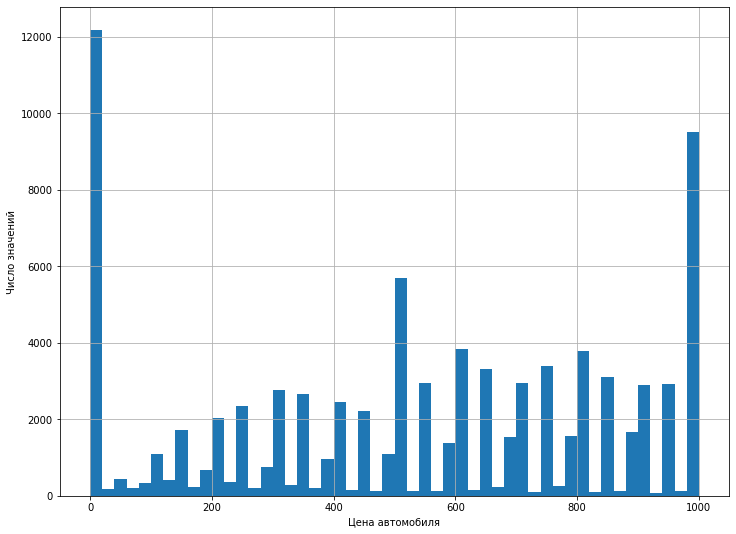

In [11]:
# График цены в районе низких аномальных значений
ax = df['Price'].hist(bins=50, figsize=(12,9), range=(0, 1000));
ax.set_xlabel('Цена автомобиля')
ax.set_ylabel('Число значений')

<span style="color:green">
Посмотрим на различные квантили распределения цен на автомобили:
</span>

In [12]:
# Нижний квантиль - 2.5%, верхний квантиль - 97.5%
lower_quantile = df['Price'].quantile(q=0.025)
higher_quantile = df['Price'].quantile(q=0.975)
print(f'Quantiles: {lower_quantile} - {higher_quantile}')
df['Price'].to_frame().query('Price >= @lower_quantile and Price <= @higher_quantile').count()

Quantiles: 0.0 - 16900.0


Price    345763
dtype: int64

In [13]:
# Нижний квантиль - 5%, верхний квантиль - 97.5%
lower_quantile = df['Price'].quantile(q=0.05)
higher_quantile = df['Price'].quantile(q=0.975)
print(f'Quantiles: {lower_quantile} - {higher_quantile}')
df['Price'].to_frame().query('Price >= @lower_quantile and Price <= @higher_quantile').count()

Quantiles: 200.0 - 16900.0


Price    328301
dtype: int64

In [14]:
# Нижний квантиль - 5%, верхний квантиль - 100.0%
lower_quantile = df['Price'].quantile(q=0.05)
higher_quantile = df['Price'].quantile(q=1.0)
print(f'Quantiles: {lower_quantile} - {higher_quantile}')
df['Price'].to_frame().query('Price >= @lower_quantile and Price <= @higher_quantile').count()

Quantiles: 200.0 - 20000.0


Price    336907
dtype: int64

<span style="color:green">
Руководствуясь целесообразностью и здравым смыслом, оставим побольше данных из датасета (спойлер - после проверки на соответствие датам будет удалено довольно много строк), оставим нижнюю границу стоимости автомобиля в 200 долларов - возможно, что машина уже не функциональна и годится только на запчасти, а верхнюю в 20000 долларов - подержанные автомобили премиум класса
</span>

<span style="color:green">
Проанализируем год регистрации автомобиля
</span>

Text(0, 0.5, 'Число значений')

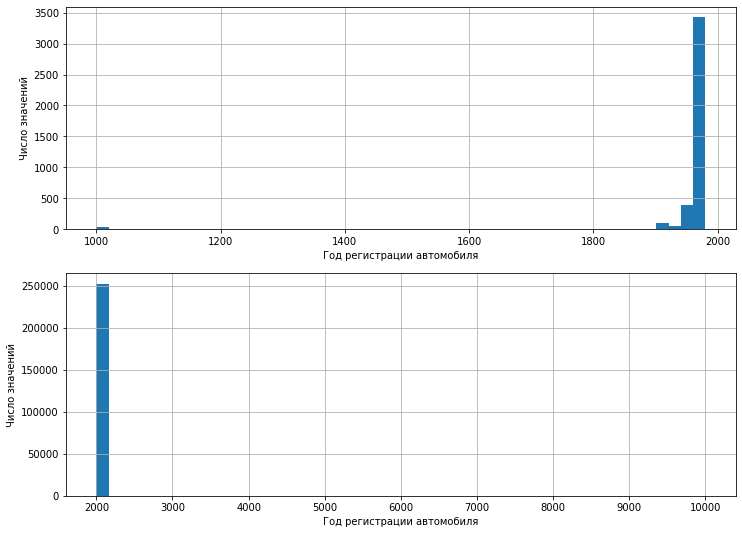

In [15]:
# График года регистрации в районе аномально низких и аномально высоких значений

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,18))

ax_0 = df['RegistrationYear'].hist(bins=50, figsize=(12,9), range=(1000, 1980), ax=ax[0]);
ax_0.set_xlabel('Год регистрации автомобиля')
ax_0.set_ylabel('Число значений')

ax_1 = df['RegistrationYear'].hist(bins=50, figsize=(12,9), range=(2000, 9999), ax=ax[1]);
ax_1.set_xlabel('Год регистрации автомобиля')
ax_1.set_ylabel('Число значений')

<span style="color:green">
В качестве граничных значений для года регистрации автомобиля оставим с 1950 по 2022-й
</span>

<span style="color:green">
Осуществим проверку регистрации автомобиля по полю 'DateCrawled'
</span>

In [16]:
df['DateCrawled'] = df['DateCrawled'].apply(pd.to_datetime)
df['year_download'] = df['DateCrawled'].dt.year

df = df.query('RegistrationYear <= year_download and RegistrationYear >= 1950')
df.drop(['year_download'], axis=1, inplace=True)

<span style="color:green">
Оценим границы диапазона мощностей двигателей
</span>

In [17]:
df['Power'].to_frame().query('Power < 40').count()

Power    37683
dtype: int64

In [18]:
df['Power'].to_frame().query('Power > 350').count()

Power    1141
dtype: int64

Text(0, 0.5, 'Число значений')

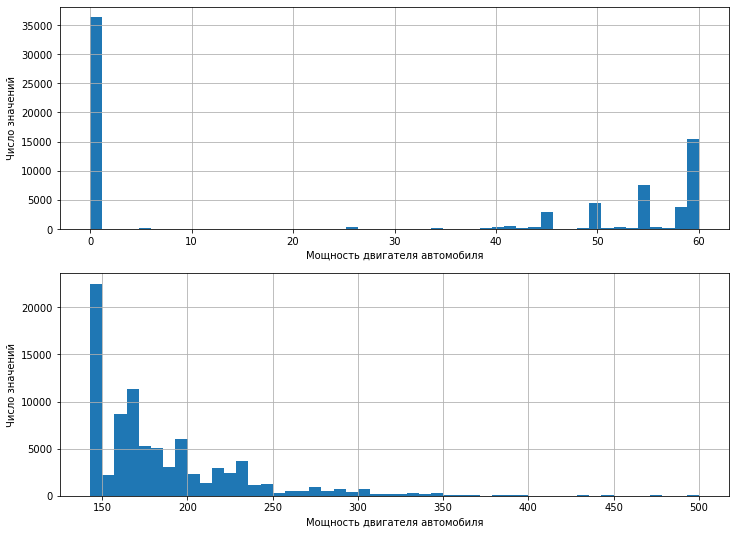

In [19]:
# График мощности двигателя в районе аномально низких и аномально высоких значений

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,18))

ax_0 = df['Power'].hist(bins=50, figsize=(12,9), range=(0, 60), ax=ax[0]);
ax_0.set_xlabel('Мощность двигателя автомобиля')
ax_0.set_ylabel('Число значений')

ax_1 = df['Power'].hist(bins=50, figsize=(12,9), range=(143, 500), ax=ax[1]);
ax_1.set_xlabel('Мощность двигателя автомобиля')
ax_1.set_ylabel('Число значений')


<span style="color:green">
Увы, похоже что в данных присутствует фатальная ошибка - около 40000 объявлений содержат записи от том, что мощность двигателя 0-2 лошадиные силы, что заведомо абсурдно, но как это исправить, увы, непонятно. С другой стороны, просто так выбросить эти значения сложно, так как их слишком много (> 10% от общего числа строк) Но все равно установим диапазон мощностей от 40 до 350 л.с. (это хотя бы похоже на правду)
</span>

<span style="color:green">
Таким образом, предварительно преобразуем наши данные так, чтобы не было бесполезных и аномальных значений:<br><br>
1. Столбцы 'DateCrawled', 'NumberOfPictures' и 'PostalCode' не нужны<br>
2. Цена автомобиля от 200 долларов и выше<br>
3. Год регистрации автомобиля от 1950 года до 2022-го<br>
4. Мощность двигателя автомобиля ограничить от 40 до 350 л.с.<br>
</span>

<span style="color:green">
Логическая связь между месяцем продажи и стоимостью автомобиля, если и есть, то очень неочевидна. Удалим тогда столбец 'RegistrationMonth' из рассмотрения
</span>

In [20]:
columns_dict = {"DateCrawled" : "date_crawled", "Price": "price", "VehicleType" : "vechicle_type", "RegistrationYear" : "registartion_year", "Gearbox" : "gear_box", "Power" : "power", "Model" : "model", "Kilometer" : "kilometer", "RegistrationMonth" : "registration_month", "FuelType" : "fuel_type", "Brand" : "brand", "NotRepaired" : "not_repaired", "DateCreated" : "date_created", "NumberOfPictures" : "number_of_pictures", "PostalCode" : "postal_code", "LastSeen" : "last_seen"}
df.rename(columns = columns_dict, inplace=True)

df.drop(['date_crawled','number_of_pictures', 'postal_code', 'registration_month'], axis=1, inplace=True)

In [21]:
df = df.query('price >= @lower_quantile and price <= @higher_quantile and power >= 40 and power <= 350')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290669 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              290669 non-null  int64 
 1   vechicle_type      280427 non-null  object
 2   registartion_year  290669 non-null  int64 
 3   gear_box           285675 non-null  object
 4   power              290669 non-null  int64 
 5   model              280176 non-null  object
 6   kilometer          290669 non-null  int64 
 7   fuel_type          276038 non-null  object
 8   brand              290669 non-null  object
 9   not_repaired       249541 non-null  object
 10  date_created       290669 non-null  object
 11  last_seen          290669 non-null  object
dtypes: int64(4), object(8)
memory usage: 28.8+ MB


<span style="color:green">
Удаляем применение корректировки месяца регистрации за ненадобностью
</span>

In [22]:
df[['date_created', 'last_seen']] = df[['date_created', 'last_seen']].apply(pd.to_datetime)
df['sales_days_active'] = (df['last_seen'] - df['date_created']).dt.days
df.drop(['date_created', 'last_seen'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290669 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              290669 non-null  int64 
 1   vechicle_type      280427 non-null  object
 2   registartion_year  290669 non-null  int64 
 3   gear_box           285675 non-null  object
 4   power              290669 non-null  int64 
 5   model              280176 non-null  object
 6   kilometer          290669 non-null  int64 
 7   fuel_type          276038 non-null  object
 8   brand              290669 non-null  object
 9   not_repaired       249541 non-null  object
 10  sales_days_active  290669 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 26.6+ MB


<span style="color:green">
Тем не менее, остаются пропущенные значения у 'VechicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'. Конечно, можно сказать, что LightGBM умеет работать с пропущенными данными и остановиться на этом. Но все-таки прикинем сценарий, восстановления данных.<br><br>
Для поля 'NotRepaired' мы вряд ли придумаем достоверный способ определения, была ли машина в ремонте (имеется в виду в РЕМОНТЕ) или нет. Поэтому проще - ввести категорию n/a и работать с тремя категориями - ибо таких пропущенных значений тут очень много и просто выбросить и не получится. Вариант два - привести данные в числовой формат и посмотреть кореляцию с годом выпуска машины - логично было бы, что че старше машина, тем с большей вероятностью она проходила крупный ремонт. Но опять же - это будет вероятностная экстраполяция данных, которая внесет дополнительную ошибку в предсказания.<br><br>
У поля 'FuelType' однозначное восстановление значение маловероятно, так как у многих моделей двигатель может быть как бензиновым, так и дизельным. <br>
'Model' - в принципе, однозначно восстановить нельзя, так как производитель машини, ее класс, коробка передач и тип топлива однозначно не смогут определить ее модель<br>
'VechicleType' по 'Model', однако и здесь возможны сложности, так как например Volkswagen Golf бывает и 'small' и 'wagon'<br>
'GearBox' - возможен вариант, что у одной модели может быть как ручная так и автоматическая коробка передач (это справедливо для машин не стараше, как минимум, пятнадцати лет)
</span>

<span style="color:green">
Введем новый тип в колонке 'not_repaired'
</span>

In [23]:
df['not_repaired'] = df['not_repaired'].fillna(value='n/a')

<span style="color:green">
На всякий случай, сохраним данные для целикового анализа в LightGBM
</span>

In [24]:
df_init = df.copy()
categorical = ['vechicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'not_repaired']

<span style="color:green">
Дополнительно создадим список некатегориальных параметров
</span>

In [25]:
non_categorical = ['registartion_year', 'power', 'kilometer', 'sales_days_active']

<span style="color:green">
Выбросим все строки, где нет модели автомобиля
</span>

In [26]:
df.drop(df[pd.isna(df['model'])].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280176 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              280176 non-null  int64 
 1   vechicle_type      271392 non-null  object
 2   registartion_year  280176 non-null  int64 
 3   gear_box           275796 non-null  object
 4   power              280176 non-null  int64 
 5   model              280176 non-null  object
 6   kilometer          280176 non-null  int64 
 7   fuel_type          268032 non-null  object
 8   brand              280176 non-null  object
 9   not_repaired       280176 non-null  object
 10  sales_days_active  280176 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.7+ MB


<span style="color:green">
Восстановим поле 'vechicle_type'
</span>

In [27]:
#tmp = df.groupby(['model', 'vechicle_type'], as_index=False)['price'].count() # 100 = wagon, 145 = small, 147 = sedan, 156 = sedan, zafira = bus
tmp = df.groupby(['model', 'vechicle_type'], as_index=False)['price'].count().sort_values('price').drop_duplicates(subset=['model'], keep='last')

model_vechicle_dict = {}
model_vechicle_dict = dict(zip(tmp.model, tmp.vechicle_type))

df['vechicle_type'] = df['vechicle_type'].fillna(df['model'].map(model_vechicle_dict))

<span style="color:green">
Восстановим поле 'fuel_type'
</span>

In [28]:
tmp = df.groupby(['model', 'fuel_type'], as_index=False)['price'].count().sort_values('price').drop_duplicates(subset=['model'], keep='last')

model_fuel_dict = {}
model_fuel_dict = dict(zip(tmp.model, tmp.fuel_type))
df['fuel_type'] = df['fuel_type'].fillna(df['model'].map(model_fuel_dict))

<span style="color:green">
Восстановим поле 'gear_box'
</span>

In [29]:
tmp = df.groupby(['model', 'gear_box'], as_index=False)['price'].count().sort_values('price').drop_duplicates(subset=['model'], keep='last')

model_gear_dict = {}
model_gear_dict = dict(zip(tmp.model, tmp.gear_box))
df['gear_box'] = df['gear_box'].fillna(df['model'].map(model_gear_dict))

<span style="color:green">
Для дальнейших исследований сохраним копии очищенного и заполненного датасета
</span>

In [30]:
df_forest = df.copy()
df_sgd = df.copy()

## Обучение моделей

<span style="color:green">
Начнем с датасета с <b>пропущенными</b> данными
<br><br>
Выделим искомые признаки и параметры регрессии. Затем разобьем выборку на учебную и тестовую. И подберем наилучшие параметры для LightGBM
</span>

In [31]:
state = RandomState(123)

for cat in categorical:
    df_init[cat] = pd.Series(df_init[cat], dtype='category')

features_nf = df_init.drop(['price'], axis=1)
target_nf = df_init['price']

features_train_init_nf, features_test_init_nf, target_train_init_nf, target_test_init_nf = train_test_split(features_nf, target_nf, test_size=0.2, random_state=123)

In [32]:
lgb_params = {"n_estimators" : range(40,101,10), "max_depth" : range(5,15)}
lgb_estimator = lgb.LGBMRegressor(random_state=state)
lgb_grid_search_nf = GridSearchCV(lgb_estimator, lgb_params, cv=5, scoring='neg_mean_squared_error')
lgb_grid_search_nf.fit(features_train_init_nf, target_train_init_nf)
best_lgb_params_nf = lgb_grid_search_nf.best_params_
best_lgb_rmse_nf = lgb_grid_search_nf.best_score_
print(f'Gradient Boosting (not filled data) best params: {best_lgb_params_nf}')
print(f'Gradient Boosting (not filled data) best RMSE: {np.sqrt(-best_lgb_rmse_nf)}')

Gradient Boosting (not filled data) best params: {'max_depth': 9, 'n_estimators': 100}
Gradient Boosting (not filled data) best RMSE: 1546.4157276000547


<span style="color:green">
Теперь перейдем к датасету с <b>заполенными</b> данными
</span>

In [33]:
for cat in categorical:
    df[cat] = pd.Series(df[cat], dtype='category')

features_fl = df.drop(['price'], axis=1)
target_fl = df['price']

features_train_fl, features_test_fl, target_train_fl, target_test_fl = train_test_split(features_fl, target_fl, test_size=0.2, random_state=123)

In [34]:
# lgb_estimator = lgb.LGBMRegressor(random_state=state)
lgb_grid_search_fl = GridSearchCV(lgb_estimator, lgb_params, cv=5, scoring='neg_mean_squared_error')
lgb_grid_search_fl.fit(features_train_fl, target_train_fl)
best_lgb_params_fl = lgb_grid_search_fl.best_params_
best_lgb_rmse_fl = lgb_grid_search_fl.best_score_
print(f'Gradient Boosting (filled data) best params: {best_lgb_params_fl}')
print(f'Gradient Boosting (filled data) best RMSE: {np.sqrt(-best_lgb_rmse_fl)}')

Gradient Boosting (filled data) best params: {'max_depth': 11, 'n_estimators': 100}
Gradient Boosting (filled data) best RMSE: 1529.307437161819


<span style="color:green">
Как можно видеть, градиентный бустинг дал неплохие результат как для полностью заполненных данными датасетов, так и для датасетов с пропусками. Однако, в дальнейшем нам понадобится сравнение с другими регрессионными алгоритмами, где пропуск данных уже неприемлем, поэтому примем пока вариант работы LightGBM на заполненном датасете с наилучшим RMSE результатом в 1529.3 доллара
</span>

## Анализ моделей

<span style="color:green">
Для анализа результатов градиентного бустинга рассмотрим лес дереьвев и наивный алгоритм регрессии. Работать будем над датасетом dt с заполненными пропущенными значениями
</span>

<span style="color:green">
Рассмотрим возможность предсказания данных с помощью <b>леса деревьев регрессии</b>
<br><br>
Для этого случая с помощью Ordinal Encoder преобразуем категориальные значения в целочисленные
</span>

<span style="color:green">
Заодно, засечем время, которое будет потрачено на GridSearch лучших параметров регрессии (это 5 * 4 * 7 = 140 операций fit и predict для случайного леса)
</span>

In [35]:
features_frst = df_forest.drop(['price'], axis=1)
target_frst = df_forest['price']

encoder = OrdinalEncoder()
encoder.fit(features_frst[categorical])
features_frst[categorical] = encoder.transform(features_frst[categorical])
features_frst[categorical] = features_frst[categorical].astype(np.int64)

features_train_frst, features_test_frst, target_train_frst, target_test_frst = train_test_split(features_frst, target_frst, test_size=0.2, random_state=123)


param_grid_frst = {'n_estimators': range(40,101,20), 'max_depth': range(3,10)}
random_forest_regressor = RandomForestRegressor(random_state=state)
grid_search_frst = GridSearchCV(random_forest_regressor, param_grid_frst, cv=5, scoring='neg_mean_squared_error')

start_time = time.time()
grid_search_frst.fit(features_train_frst, target_train_frst)
elapsed_time = time.time() - start_time

forest_best_params_frst = grid_search_frst.best_params_
forest_best_rmse_frst = grid_search_frst.best_score_

print(f'Random Forest best params: {forest_best_params_frst}')
print(f'Random Forest best RMSE: {np.sqrt(-forest_best_rmse_frst)}')
print(f'Full time elapced: {elapsed_time}, rough mean time per forest unit is {elapsed_time / 140}')

Random Forest best params: {'max_depth': 9, 'n_estimators': 100}
Random Forest best RMSE: 1894.1423123801972
Full time elapced: 1270.8325626850128, rough mean time per forest unit is 9.077375447750091


<span style="color:green">
Итак, на все про все ушло 21 минута 11 секунд, а грубая прикидка среднего времени времени обучения и предсказания леса деревьев - 9 секунд. Разумеется, 9 секунд - это <b>очень прикидочное неточное значение</b> поскольку глубина и количество деревьев менялись по ходу поиска оптимальных параметров, но тем не менее, это дает нам представление о порядке величины времени работы алгоритма. И вывод - работа идет весьма медленно, особенно, если посмотреть на 1 минуты 59 секунд решетчатого поиска LightGBM (с 7*10*5=350-и итерациями кросс-валидации - то есть, прикидочно, 0.34 сек на обучение и предсказание)
</span>

<span style="color:green">
Теперь попробуем применить <b>стохастический градиентный спуск</b>
<br><br>
Здесь используем One Hot Encoding для преобразования категориальных значений в целочисленные, а потом применим скалирование для не-категориальных значений
</span>

<span style="color:green">
Также засечем время, которое будет потрачено на кросс-валидацию и обучение алгоритма
</span>

In [35]:
df_sgd = pd.get_dummies(df_sgd, columns=categorical, drop_first=True)
features_sgd = df_sgd.drop(['price'], axis=1)
target_sgd = df_sgd['price']
features_train_sgd, features_test_sgd, target_train_sgd, target_test_sgd = train_test_split(features_sgd, target_sgd, test_size=0.2, random_state=123)

scaler = StandardScaler()

scaler.fit(features_train_sgd[non_categorical])
features_train_sgd[non_categorical] = scaler.transform(features_train_sgd[non_categorical])
features_test_sgd[non_categorical] = scaler.transform(features_test_sgd[non_categorical])

sgd_reg = SGDRegressor(random_state = 123)

start_time = time.time()
cross_val_scores_sgd = cross_val_score(sgd_reg, features_train_sgd, target_train_sgd, cv=5, scoring='neg_mean_squared_error', verbose=50)
cross_val_time = time.time() - start_time

print(f'SGD cross-validation scores: {-cross_val_scores_sgd}')
print(f'Mean cross-validation RMSE: {np.mean(np.sqrt(-cross_val_scores_sgd))}')
print(f'Cross_val_time: {cross_val_time}')

<ipython-input-35-aec0ad36c0a5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_sgd[non_categorical] = scaler.transform(features_train_sgd[non_categorical])
c:\Users\Артем\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-35-aec0ad36c0a5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] START .....................................................................
[CV] END ......................... score: (test=-6204276.576) total time=  12.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s
[CV] START .....................................................................
[CV] END ......................... score: (test=-6458166.530) total time=  16.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.2s remaining:    0.0s
[CV] START .....................................................................
[CV] END ......................... score: (test=-6466045.996) total time=  12.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.8s remaining:    0.0s
[CV] START .....................................................................
[CV] END ......................... score: (test=-6344322.727) total time=  13.8s
[Parallel(n_jobs=1)]: Done   4 

<span style="color:green">
Здесь на пять операций кросс-валидации (обучение + предсказание) ушло 73.36 секнуды, то есть <b>примерно</b> по 14.7 секунды на одну итерацию fit+predict - тоже довольно много
</span>

<span style="color:green">
Итак, для леса деревьев регрессии мы получили RMSE равный 1894.1 доллара а для стохастического градиентного спуска - 2526.08 доллара. Так что по критерию RMSE оба этих подхода уступают LightGBM
</span>

<span style="color:green">
Замерим времена для обучения и предсказания для LightGBM, Random Forest и SGD, а также сравним результат предсказания с наивным регрессионным алгоритмом
</span>

<span style="color:green">
Поскольку по результатам кросс-валидации лучше всего себя показал алгоритм LightGBM, а также по замерам средних времен на одну операцию кросс-валидации (обучение и предсказание) скорость работы LightGBM также превысила аналогичные скорости Random Forest и SGD, проведем тестирование вместе с еще одним контрольным замером времени обучения и предсказания на LightGBM модели
</span>

<span style="color:green">
<b>LightGBM</b>
</span>

In [36]:
train_data = lgb.Dataset(features_train_fl, target_train_fl)
best_params = {"n_estimators" : best_lgb_params_fl['n_estimators'], "max_depth" : best_lgb_params_fl['max_depth'], "random_state" : 123}

# Обучение
start_time = time.time()
model_best_filled = lgb.train(best_params, train_set=train_data)
lgb_learn_time = time.time()-start_time

# Предсказание
start_time = time.time()
target_predict = model_best_filled.predict(features_test_fl)
lgb_predict_time = time.time()-start_time
rmse = np.sqrt(mean_squared_error(target_test_fl, target_predict))
print(f'LightGBM prediction RMSE: {rmse}')
print(f'LightGBM fit time: {lgb_learn_time},  prediction time: {lgb_predict_time}')

c:\Users\Артем\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 224140, number of used features: 10
[LightGBM] [Info] Start training from score 4944.781007
LightGBM prediction RMSE: 1503.927209502898
LightGBM fit time: 0.44628190994262695,  prediction time: 0.07782793045043945


<span style="color:green">
<b>Наивный алгоритм</b>
</span>

In [37]:
dummy_algo = DummyRegressor(strategy='mean')
dummy_algo.fit(features_train_fl, target_train_fl)
target_predict = dummy_algo.predict(features_test_fl)
dummy_rmse = np.sqrt(mean_squared_error(target_test_fl, target_predict))
print(f'Best dummy RMSE: {dummy_rmse}')

Best dummy RMSE: 4593.72981786537


<span style="color:green">
Выводы по скорости обучения и предсказания алгоритмов таковы:<br><br>
Стохастический градиентный спуск - очень долго обучается - 25.7 секунд, быстро дает предсказание - 0.04 секунды. Однако, несмотря на высокую скороть вычисления предсказания, он не годится из-за плохих предыдущих результатов кросс-валидации (на тестовой выборке он также показал себя плохо) и долгого обучения<br><br>
Лес деревьев - долгое обучение - 23 секунды, довольно долгое предсказание - 0.37 секунды. Хотя кросс-вадидация дала неплохой результат RMSE (да и на тестовой выборке он не ухудшился), все равно алгоритм придется отбросить из-за долгого обучения<br><br>
Градиентный бустинг показал кие скорости обучения и предсказания - 0.4 секунды и 0.08 секунд, соответсвенно. Также он не ухудшил результат на тестовой выборке<br><br>
Наивный алгоритм регрессии показывает, что в принципе, задача поддается всем трем перечисленным алгоритмам и результат их работы в любом случае применим для прогнозирования
</span>

<span style="color:green">
<h3>Выводы</h3>
<br>
Была проведена работа над подготовкой и восстановлением данных. Алгоритм градиентного бустинга в реализации LightGBM умеет оперировать с отсутствующими и категориальными данными, что и было показано выше на датасете с пропущенными значениями и восстановленными значениями. При этом был достигнут весьма хороший результат по точности предсказания стоимости автомобиля - RMSE = 1594 долларов при быстрой скорости работы алгоритма.<br>
Для сранения был взят лес деревьев регрессии который не умеет работыть с пропущенными и категориальными данными - для этого категориальные данные пришлось заменять на целочисленные. Вместе с этим скорость работы отсатется низкой и качество предсказания стоимости автомобиля хуже - RMSE = 2398 долларов<br>
Наивный алгоритм регрессии дает слишком высокое значение RMSE = 4573, что подтверждает то, что представленные алгоритмы регрессии дают довольно точные предсказания.
</span>

<span style="color:green">
По совокупности результатов работы (RMSE, скорость обучения, скорость предсказания) из трех алгоритмов - SGD, Random Forest, LightGBM для работы с данными по предсказанию цены автомобиля можно рекомендовать градиентный бустинг
</span>